In [1]:
from rnn_model import *
import cv2

from keras.models import Sequential
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K
from keras.utils.np_utils import to_categorical   
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv3D


# Tensorflow
import tensorflow as tf
print(tf.__version__)

# I/O libraries
import os
import tarfile
import tempfile
from six.moves import urllib

# Helper libraries
import random
import matplotlib
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2 as cv
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
from tqdm import tqdm

from jupyter_nb import seg_elevation

Using TensorFlow backend.



1.15.0


In [ ]:
# In Many-To-Many Rnn network
# X: 5D tensor with shape: (samples, time, rows, cols, channels)
# Y: 5D tensor with shape: (samples, time, output_row, output_col, filters=num_classes)

# def gen_data(main_dir, batch_size, num_frames=10, INPUT_SHAPE=(360, 640)):
#     i = 0
#     start_frames = range(0, 5000, batch_size)
#     while True:
#         input_batch = []
#         output_batch = []
#         for b in range(batch_size):
#             if i == len(start_frames):
#                 i = 0
#                 random.shuffle(start_frames)
#             input_imgs = []
#             output_imgs = []
#             # print(start_frames[i])
#             for k in range(num_frames):
#                 input_file = os.path.join(main_dir, 'infer', '00{:04d}_if_id.png'.format(start_frames[i+k]))
#                 gt_file = os.path.join(main_dir, 'corrected_gt_id', '00{:04d}_gt_id.png'.format(start_frames[i+k]))
#                 # print(input_file, " ", gt_file)
#                 infer_img = cv2.resize(cv2.imread(input_file, cv2.IMREAD_GRAYSCALE), INPUT_SHAPE)[..., np.newaxis]
#                 gt_img = cv2.resize(cv2.imread(gt_file, cv2.IMREAD_GRAYSCALE), INPUT_SHAPE)[..., np.newaxis]
#                 # print(infer_img.shape)
#                 input_imgs.append((infer_img.astype(float) - 10) / 10)
#                 output_imgs.append((gt_img.astype(float) - 10) / 10)
#             i += 1
#             input_batch.append(input_imgs)
#             output_batch.append(output_imgs)
#         input_batch = np.array(input_batch)
#         output_batch = np.array(output_batch)
#         print(input_batch.shape, ' ', output_batch.shape)
#         yield input_batch, output_batch   

In [2]:
def build_conv_lstm_model(height, width, num_channels, num_classes):
    seq = Sequential()
    seq.add(ConvLSTM2D(filters=40, kernel_size=(3,3),
                       input_shape=(None, height, width, num_channels),
                       padding='same', data_format='channels_last',
                       return_sequences=True))
    seq.add(BatchNormalization())   
    seq.add(ConvLSTM2D(filters=40, kernel_size=(3,3),
                       padding='same',
                       return_sequences=True))
    seq.add(BatchNormalization())
    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       padding='same', return_sequences=True))
    seq.add(BatchNormalization())
    seq.add(Conv3D(filters=20, kernel_size=(3, 3, 3),
                   activation='softmax',
                   padding='same', data_format='channels_last'))    
#    run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
    # opt = Adam(lr=0.05, beta_1=0.9, beta_2=0.999, decay=0.01)
    seq.compile(
        optimizer='adam',
        # optimizer=opt,
        # loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        # loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
    return seq

In [5]:
def gen_mit_data(ds_dir='/home/ubuntu/mit_driveseg_dataset/npz_files', 
                 batch_size=1,
                 start_idx = 1,
                 dataset_size=100):
    batchs = list(range(start_idx, dataset_size+start_idx))
    num_examples = 10
    while True:
        # print('one epoch')
        random.shuffle(batchs)
        # print(batchs)
        for batch_idx in batchs:
            data = np.load(os.path.join(ds_dir, 'ds{:04d}.npz'.format(batch_idx)))
            print('\nload ', 'ds{:04d}.npz'.format(batch_idx), '\n')
            num_frames = data['X'].shape[0]
            # print(int(num_frames/num_examples))
            X = data['X'].reshape((num_examples, int(num_frames/num_examples), 360, 640, 22))
            Y = data['Y'].reshape((num_examples, int(num_frames/num_examples), 360, 640, 1))
            data.close()
            # print(X.shape, ' ', Y.shape) 
            Y = to_categorical(Y, num_classes=20)
            k = list(range(num_examples//batch_size))
            random.shuffle(k)
            for kk in k:
                yield X[kk*batch_size:(kk+1)*batch_size], Y[kk*batch_size:(kk+1)*batch_size]

In [ ]:
# # check if the reshape is correct.
# ds_dir='/home/ubuntu/mit_driveseg_dataset/npz_files'
# data = np.load(os.path.join(ds_dir, 'ds{:04d}.npz'.format(1)))
# print(data['X'].shape)
# Y = data['Y'].reshape((1, 1, 360, 640, 1))
# print(Y.shape)
# print(data['X'].reshape((1, 1, 360, 640, 22)).shape)
# #print(np.array_equal(Y[1, 3],data['Y'][8]))
# print(data['X'][0,:10,:10,:3])

In [4]:
seq = build_conv_lstm_model(360, 640, 22, 20)
seq.summary()

## test purpose
# for x, y in gen_mit_data(dataset_size=1, batch_size=1):
#     print(x.shape, " ", y.shape)
#     break
# print(x.shape, y.shape)
# seq.fit(x,y, batch_size=1, epochs = 10)


# 1-60: training set
# 60-80: val set
# each file contains:
#   input x: 10 (num_examples) x 5(num_frames) x 360 (height) x 640 (width) x 22(num_channels, 3 rgb +19)
#   output y: 10 (num_examples) x 5(num_frames) x 360 (height) x 640 (width) x 20(one-hot vector 
#             for 19+1(void) classes)
seq.fit_generator(gen_mit_data(batch_size=1, start_idx = 1, dataset_size=60), 
                  steps_per_epoch=600, epochs = 1,
                  validation_data=gen_mit_data(batch_size=1, start_idx=61, dataset_size=20), validation_steps=200)
seq.save('mit_model_v2.h5')






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 360, 640, 40 89440     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 360, 640, 40 160       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 360, 640, 40 115360    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 360, 640, 40 160       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 360, 640, 40 115360    
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 360, 640, 40 160       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, None, 360, 640, 20 21620     
Total


load  ds0084.npz 

(1, 5, 360, 640, 22)   (1, 5, 360, 640, 20)
(1, 5, 360, 640, 20)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


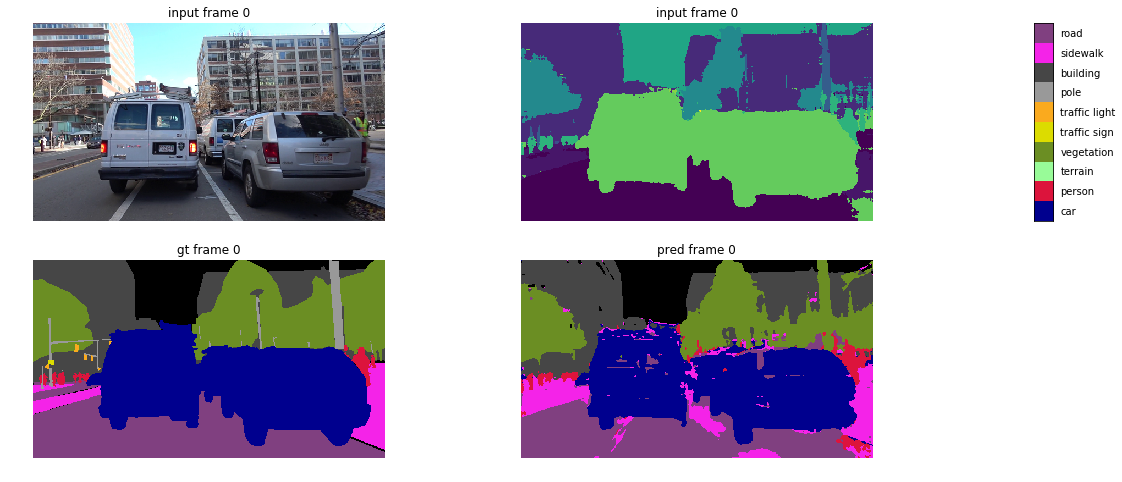

In [7]:
from keras.models import load_model

# load model
# loaded_seq = load_model('mit_model_v2.h5')

# loaded_seq.summary()
for x, y in gen_mit_data('/home/ubuntu/mit_driveseg_dataset/npz_files', batch_size=1,
                          start_idx = 84, dataset_size=1):
    print(x.shape, " ", y.shape)
    break                        

plt.figure(figsize=(20, 8))
grid_spec = gridspec.GridSpec(2, 3, width_ratios=[6, 6, 2])

plt.subplot(grid_spec[0])
plt.imshow(x[0,0][:,:,:3].astype(int))
plt.axis('off')
plt.title('input frame {}'.format(0))

plt.subplot(grid_spec[1])
plt.imshow(np.argmax(x[0,0][:,:,3:], axis=2), alpha=1)
plt.axis('off')
plt.title('input frame {}'.format(0))

plt.subplot(grid_spec[3])
plt.imshow(seg_elevation.label_to_color_image(np.argmax(y[0,0], axis=2)))
plt.title('gt frame {}'.format(0))
plt.axis('off')


seg_maps = seq.predict(x[:1])
print(seg_maps.shape)

plt.subplot(grid_spec[4])
plt.imshow(seg_elevation.label_to_color_image(np.argmax(seg_maps[0,0], axis=2)))
plt.axis('off')
plt.title('pred frame {}'.format(0))

ax = plt.subplot(grid_spec[2])
plt.imshow(seg_elevation.FULL_COLOR_MAP[seg_elevation.LABELS_TO_COMP].astype(np.uint8), interpolation='nearest')
ax.yaxis.tick_right()
plt.yticks(range(len(seg_elevation.LABELS_TO_COMP)), seg_elevation.LABEL_NAMES[seg_elevation.LABELS_TO_COMP])
plt.xticks([], [])
ax.tick_params(width=0.0)
plt.grid('off')
plt.show()